# Convolutional Neural Network Model for Land Classification using VGG19

In [14]:
# Suppress warnings from libraries to keep the output clean
import warnings
warnings.filterwarnings('ignore')

# Import standard Python libraries
import os  # For operating system dependent functionality
import shutil  # For file operations like copying and removing files
import itertools  # For advanced iteration operations
import random  # For generating random numbers

# Import scientific computing libraries
import pandas as pd  # For data manipulation and analysis
import numpy as np  # For numerical operations

# Import libraries for plotting and visualization
import matplotlib.pyplot as plt  # For creating static, animated, and interactive visualizations
import matplotlib.image as mpimg  # For reading image files

# Import TensorFlow, a deep learning library
import tensorflow as tf

# Import Keras, a high-level API for building and training deep learning models
import tensorflow.keras
from tensorflow.keras import models
from tensorflow.keras import backend as K  # For accessing the Keras backend
from tensorflow.keras.applications import imagenet_utils  # Utilities for ImageNet data
from tensorflow.keras.preprocessing.image import ImageDataGenerator  # For real-time data augmentation
from tensorflow.keras.preprocessing import image  # For image preprocessing utilities
from tensorflow.keras.metrics import categorical_crossentropy  # Loss function for multi-class classification
from tensorflow.keras.optimizers import Adam  # Optimizer for training models
from tensorflow.keras.models import Sequential, Model, load_model  # For creating and loading models

# Import various Keras layers for building neural networks
from tensorflow.keras.layers import Activation, BatchNormalization, Conv2D
from tensorflow.keras.layers import Activation, Dense, Flatten, Input, Dropout

# Import scikit-learn and SciPy libraries
from sklearn.metrics import confusion_matrix  # For computing confusion matrix
from scipy import misc, ndimage  # For image processing

# Import for plotting model architecture
from tensorflow.keras.utils import plot_model  # For creating a visual representation of the model

# Enable inline plotting in Jupyter notebooks
%matplotlib inline

In [2]:
# Restore np.random.seed to its original state
np.random.seed = np.random.seed

# Ensure np.random.seed is not reassigned
assert isinstance(np.random.seed, type(np.random.RandomState().seed)), "np.random.seed has been reassigned."

# Set up a reproducible environment
# Setting a specific hash seed for Python's hash-based operations
os.environ['PYTHONHASHSEED'] = '0'
# Setting the seed for NumPy's random number generator
np.random.seed(123)
# Setting the seed for Python's random module
random.seed(456)
# Setting the seed for TensorFlow's random number generator
tf.random.set_seed(789)

# Configure TensorFlow session to use a single thread for operations
tf.config.threading.set_intra_op_parallelism_threads(1)
tf.config.threading.set_inter_op_parallelism_threads(1)

In [3]:
# Set the path to the main dataset and the path to the train, valid and test folders within the dataset_splits folder
base_path = 'C:/Users/isaac/datasets/eurosat-dataset'
train_path = os.path.join(base_path, 'dataset_splits/train')
valid_path = os.path.join(base_path, 'dataset_splits/valid')
test_path = os.path.join(base_path, 'dataset_splits/test')

In [4]:
# Initialize an empty list to store category names
categories = []

# Walk through the directory tree starting from the specified path
for dirpath, dirnames, filenames in os.walk(base_path):
    # Filter out 'dataset_splits' directory from the list of dirnames
    # This will modify dirnames in-place and prevent os.walk from visiting this directory
    dirnames[:] = [d for d in dirnames if d != 'dataset_splits']
    
    # Add the remaining directory names (categories) to the categories list
    categories.extend(dirnames)

# Print the list of categories (subdirectory names)
print(categories)

['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']


In [5]:
# Iterate through each category within the categories list 
for category in categories:
    # Construct the path to the training images directory for the current category
    tr = os.path.join(train_path, category)
    # Get the number of training images in the current category
    len_tr = len(os.listdir(tr))

    # Construct the path to the validation images directory for the current category
    val = os.path.join(valid_path, category)
    # Get the number of validation images in the current category
    len_val = len(os.listdir(val))

    # Construct the path to the test images directory for the current category
    test = os.path.join(test_path, category)
    # Get the number of test images in the current category
    len_test = len(os.listdir(test))

    # Printing the category names and the training, validation and test images for each category
    print(category + ":")
    print('Train images for ' + category + ': {}'.format(len_tr))
    print('Validation images for ' + category + ': {}'.format(len_val))
    print('Test images for ' + category + ': {}'.format(len_test))
    print('')

AnnualCrop:
Train images for AnnualCrop: 1200
Validation images for AnnualCrop: 150
Test images for AnnualCrop: 150

Forest:
Train images for Forest: 1200
Validation images for Forest: 150
Test images for Forest: 150

HerbaceousVegetation:
Train images for HerbaceousVegetation: 1200
Validation images for HerbaceousVegetation: 150
Test images for HerbaceousVegetation: 150

Highway:
Train images for Highway: 1000
Validation images for Highway: 125
Test images for Highway: 125

Industrial:
Train images for Industrial: 1000
Validation images for Industrial: 125
Test images for Industrial: 125

Pasture:
Train images for Pasture: 800
Validation images for Pasture: 100
Test images for Pasture: 100

PermanentCrop:
Train images for PermanentCrop: 1000
Validation images for PermanentCrop: 125
Test images for PermanentCrop: 125

Residential:
Train images for Residential: 1200
Validation images for Residential: 150
Test images for Residential: 150

River:
Train images for River: 1000
Validation im

In [6]:
# Create a data generator for the training dataset
# This generator will load and preprocess images from the 'train_path' directory
train_batches = ImageDataGenerator().flow_from_directory(
    train_path,
    target_size=(64, 64),
    classes=categories,
    batch_size=20
)
# Create a data generator for the validation dataset
# This generator will load and preprocess images from the 'valid_path' directory
valid_batches = ImageDataGenerator().flow_from_directory(
    valid_path,
    target_size=(64, 64),
    classes=categories,
    batch_size=10
)
# Create a data generator for the test dataset
# This generator will load and preprocess images from the 'test_path' directory
test_batches = ImageDataGenerator().flow_from_directory(
    test_path,
    target_size=(64, 64),
    classes=categories,
    batch_size=10,
    shuffle=False)

Found 10800 images belonging to 10 classes.
Found 1350 images belonging to 10 classes.
Found 1350 images belonging to 10 classes.


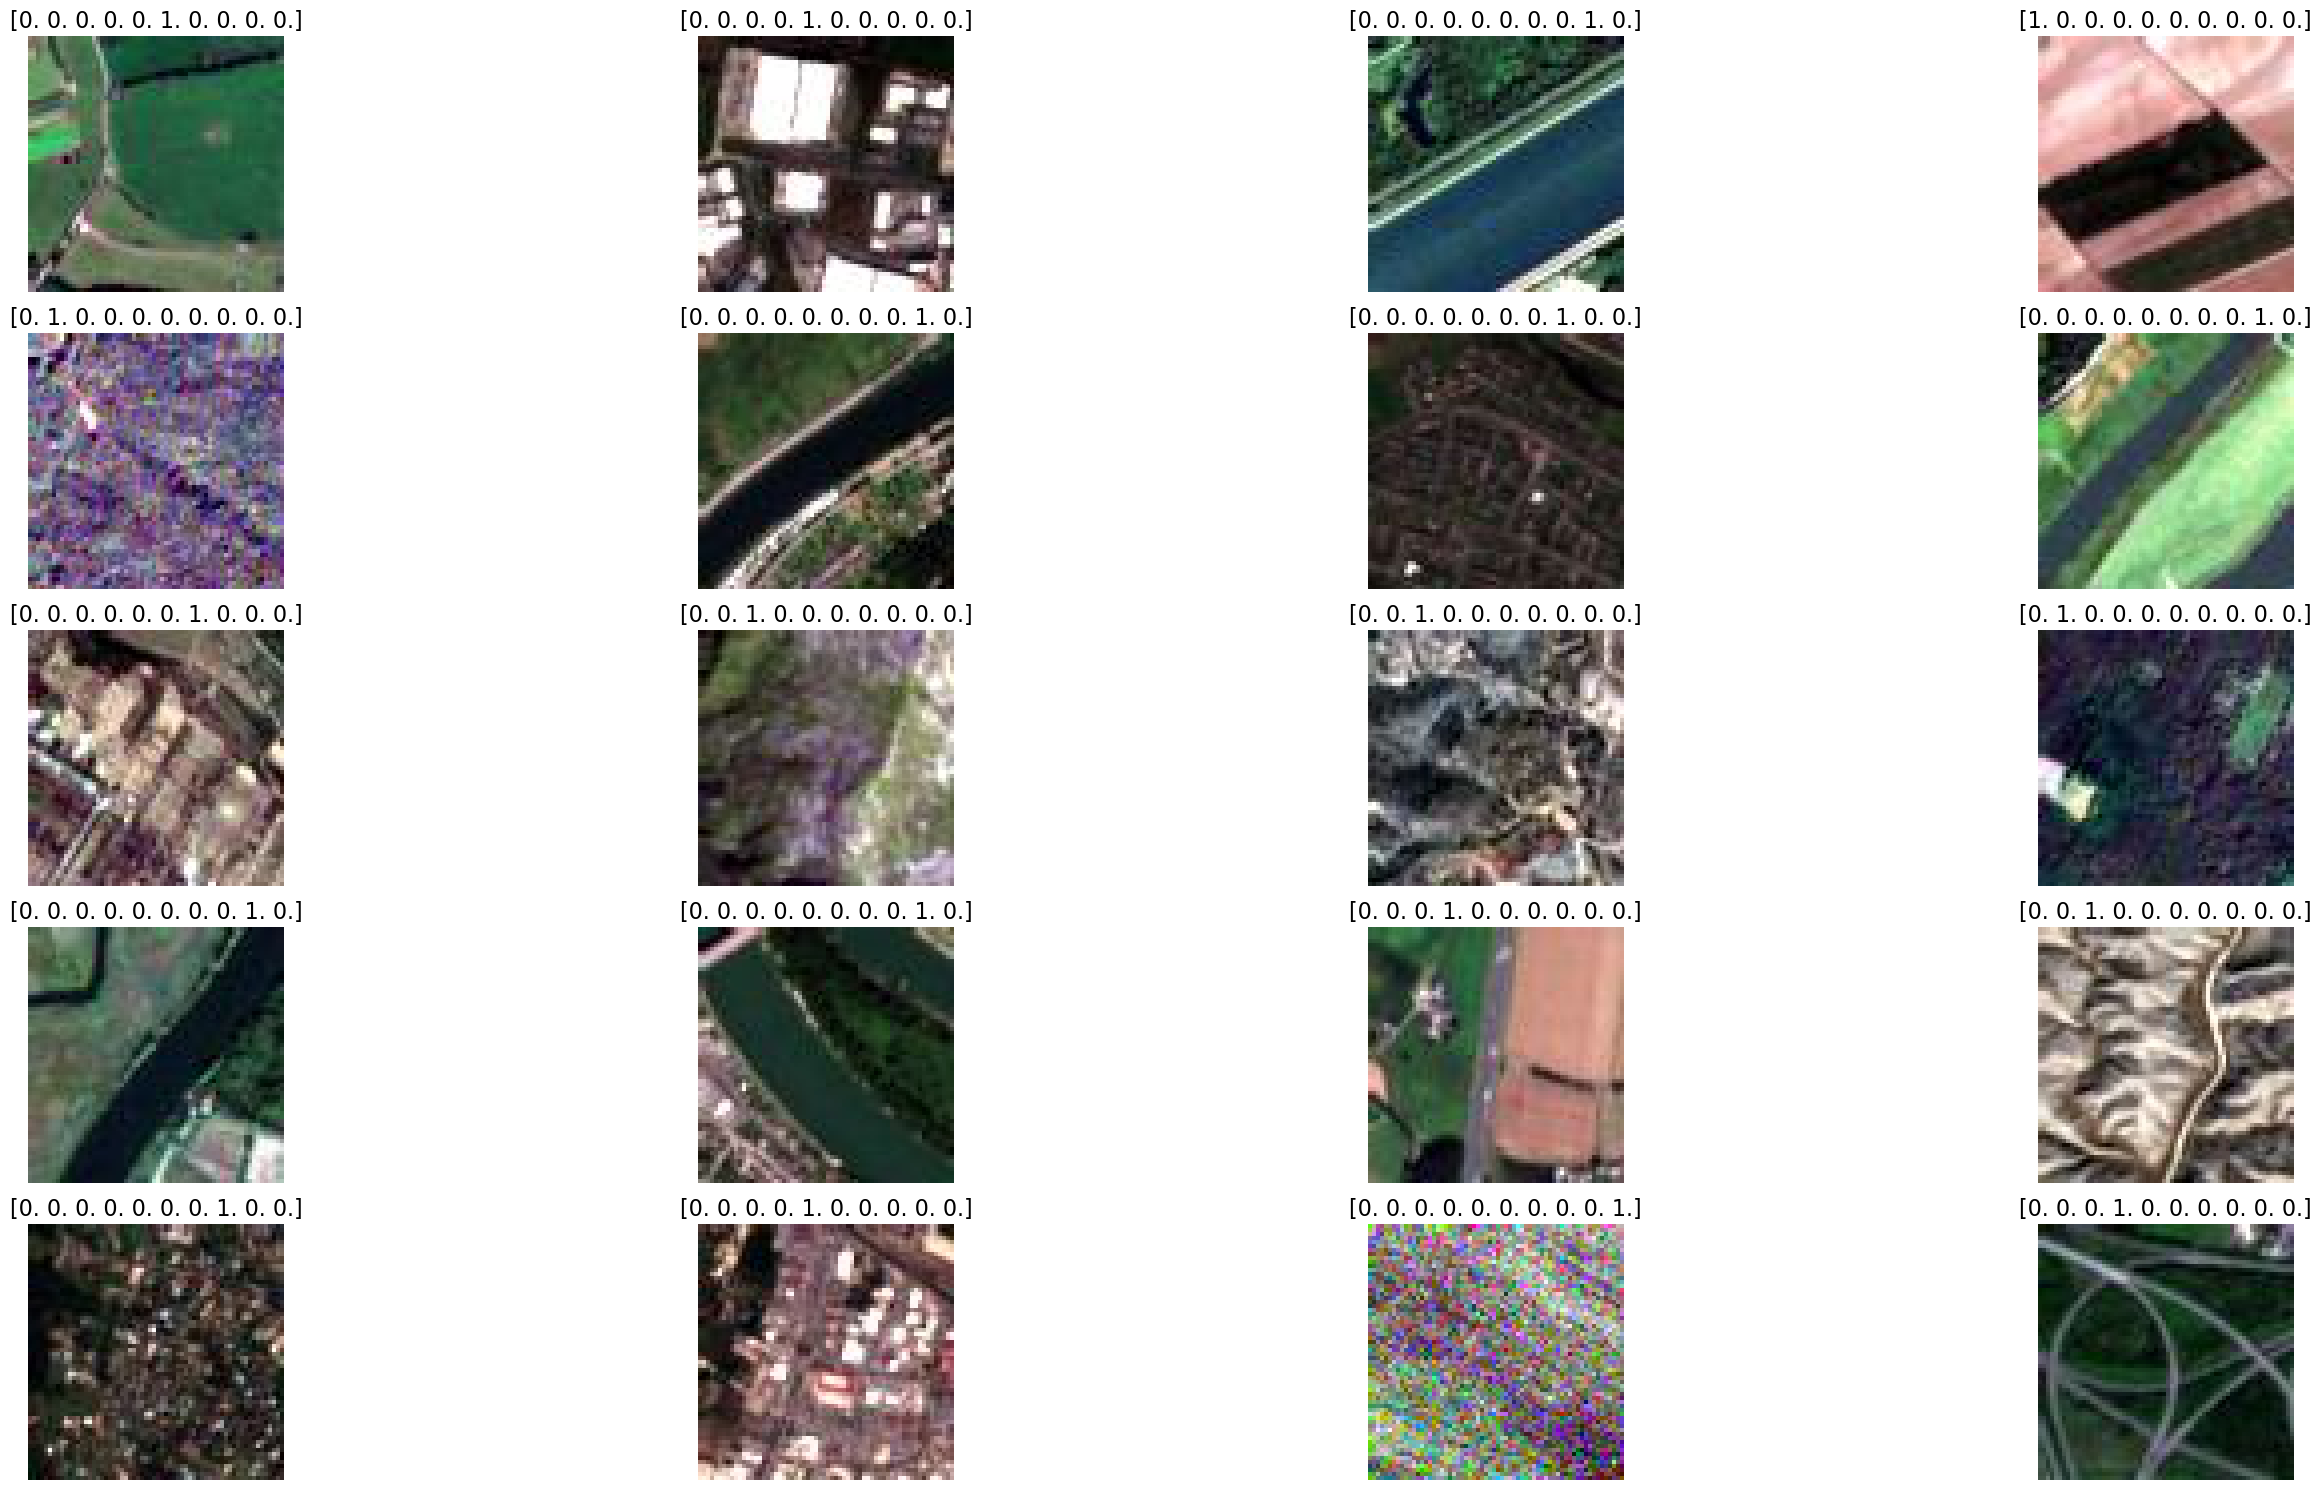

In [7]:
# Function to plot images with labels within a Jupyter notebook
# Adapted from GitHub/YouTube user deeplizard
def plots(ims, figsize=(30, 15), rows=1, interp=False, titles=None):
    # Check if the input is a list of numpy arrays
    if isinstance(ims[0], np.ndarray):
        # Convert to uint8 type for image display
        ims = np.array(ims).astype(np.uint8)
        # Ensure the images have the correct shape for display
        if ims.shape[-1] != 3:  # Check if the last dimension is not 3 (RGB channels)
            ims = ims.transpose((0, 2, 3, 1))  # Rearrange dimensions to (N, H, W, C)

    # Create a new figure with the specified size
    f, axes = plt.subplots(rows, len(ims) // rows + (len(ims) % rows != 0), figsize=figsize)
    
    # Flatten axes array if there are multiple rows
    if rows > 1:
        axes = axes.flatten()
    else:
        axes = [axes]
    
    # Iterate through images and plot them
    for i, ax in enumerate(axes):
        if i < len(ims):
            ax.axis('Off')  # Turn off axis lines and labels
            if titles is not None and i < len(titles):
                ax.set_title(titles[i], fontsize=16)  # Set title if provided
            ax.imshow(ims[i], interpolation='none' if not interp else 'bilinear')  # Display image
        else:
            ax.axis('Off')  # Hide any extra subplots
    
    plt.tight_layout()  # Adjust subplot params so that the subplot(s) fits in to the figure area
    plt.show()  # Display the figure

# Example usage with a batch of images and labels
imgs, labels = next(train_batches)  # Get a batch of images and labels from the data generator
plots(imgs, rows=5, titles=labels)  # Plot the images with titles

In [11]:
# Import VGG16 model from Keras applications module
vgg19_model = tensorflow.keras.applications.vgg19.VGG19(include_top=False, input_shape=(64,64,3))

# Display summary of the VGG16 model architecture
vgg19_model.summary()

Model: "vgg19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 64, 64, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 64, 64, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 32, 32, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 16, 16, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 16, 16, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 16, 16, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv4 (Conv2D)           │ (None, 16, 16, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 8, 8, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv4 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv4 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 2, 2, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,024,384 (76.39 MB)

 Trainable params: 20,024,384 (76.39 MB)

 Non-trainable params: 0 (0.00 B)

In [12]:
# Create a new Sequential model
model = Sequential()

# Iterate through each layer in the pre-trained VGG16 model and add it to the new model
for layer in vgg19_model.layers:
    model.add(layer)

# Display summary of the new Sequential model, which now matches the VGG16 architecture
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ block1_conv1 (Conv2D)           │ (None, 64, 64, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 64, 64, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 32, 32, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 16, 16, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 16, 16, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 16, 16, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv4 (Conv2D)           │ (None, 16, 16, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 8, 8, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv4 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv4 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 2, 2, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,024,384 (76.39 MB)

 Trainable params: 20,024,384 (76.39 MB)

 Non-trainable params: 0 (0.00 B)

In [15]:
# Freeze the weights of all layers except the last NUM_TRAINABLE_LAYERS layers
NUM_TRAINABLE_LAYERS = 10
for layer in model.layers[:-NUM_TRAINABLE_LAYERS]:
    layer.trainable = False

# Add additional layers for fine-tuning and classification
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(len(categories), activation='softmax'))

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ block1_conv1 (Conv2D)           │ (None, 64, 64, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 64, 64, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 32, 32, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 16, 16, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 16, 16, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 16, 16, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv4 (Conv2D)           │ (None, 16, 16, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 8, 8, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv4 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv4 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 2, 2, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     1,049,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │       262,65

 Total params: 21,603,914 (82.41 MB)

 Trainable params: 15,738,378 (60.04 MB)

 Non-trainable params: 5,865,536 (22.38 MB)

In [16]:
# Define the optimizer with the desired learning rate
optimizer = Adam(learning_rate=0.0001)

# Compile the model using the defined optimizer
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [20]:
# Visualize the model
plot_file_path = os.path.join(os.getcwd(), 'model_architecture.png')
plot_model(model, to_file=plot_file_path, show_shapes=True, show_layer_names=True)
print(f'Model architecture plot saved to: {plot_file_path}')

Model architecture plot saved to: C:\Users\isaac\FYP\model_architecture.png


In [17]:
%%time
history = model.fit(
    train_batches,  # Data generator for the training data
    steps_per_epoch=1080,  # Number of batches to draw from `train_batches` for each epoch
    validation_data=valid_batches,  # Data generator for the validation data
    validation_steps=270,  # Number of batches to draw from `valid_batches` for validation after each epoch
    epochs=10,  # Number of times the model will go through the entire training dataset
    verbose=2  # Level of logging verbosity (2 provides one line of output per epoch with loss and accuracy)
)

Epoch 1/10
1080/1080 - 549s - 508ms/step - accuracy: 0.1626 - loss: 2.2879 - val_accuracy: 0.2200 - val_loss: 2.0601
Epoch 2/10
1080/1080 - 537s - 497ms/step - accuracy: 0.3469 - loss: 1.7661 - val_accuracy: 0.4415 - val_loss: 1.5505
Epoch 3/10
1080/1080 - 535s - 496ms/step - accuracy: 0.5056 - loss: 1.3388 - val_accuracy: 0.5756 - val_loss: 1.1155
Epoch 4/10
1080/1080 - 515s - 476ms/step - accuracy: 0.6092 - loss: 1.0042 - val_accuracy: 0.6770 - val_loss: 0.9729
Epoch 5/10
1080/1080 - 518s - 480ms/step - accuracy: 0.7292 - loss: 0.6897 - val_accuracy: 0.7519 - val_loss: 0.6007
Epoch 6/10
1080/1080 - 529s - 489ms/step - accuracy: 0.7563 - loss: 0.5683 - val_accuracy: 0.7459 - val_loss: 0.6348
Epoch 7/10
1080/1080 - 550s - 510ms/step - accuracy: 0.7951 - loss: 0.5069 - val_accuracy: 0.8304 - val_loss: 0.4858
Epoch 8/10
1080/1080 - 609s - 564ms/step - accuracy: 0.8504 - loss: 0.3589 - val_accuracy: 0.8415 - val_loss: 0.4288
Epoch 9/10
1080/1080 - 871s - 806ms/step - accuracy: 0.8664 - lo

In [18]:
# Get the class indices from the test_batches ImageDataGenerator
test_labels = test_batches.classes
# Print the class indices of the test images
print(test_labels)

print()

# Get the class-to-index mapping from the test_batches ImageDataGenerator
test_batches.class_indices

[0 0 0 ... 9 9 9]



{'AnnualCrop': 0,
 'Forest': 1,
 'HerbaceousVegetation': 2,
 'Highway': 3,
 'Industrial': 4,
 'Pasture': 5,
 'PermanentCrop': 6,
 'Residential': 7,
 'River': 8,
 'SeaLake': 9}

Confusion matrix, without normalization
[[136   0   1   2   0   5   3   0   1   2]
 [  0 148   1   0   0   1   0   0   0   0]
 [  0   4 137   0   0   3   5   1   0   0]
 [  6   1   0 111   1   3   0   0   3   0]
 [  0   0   0   1 121   0   1   2   0   0]
 [  2   2   1   0   0  94   0   0   0   1]
 [  9   0   9   0   2   3 100   0   2   0]
 [  0   1   1   0   3   0   0 145   0   0]
 [  4   0   1 112   0   1   0   0   6   1]
 [  0   2   0   0   0   1   0   0   0 147]]


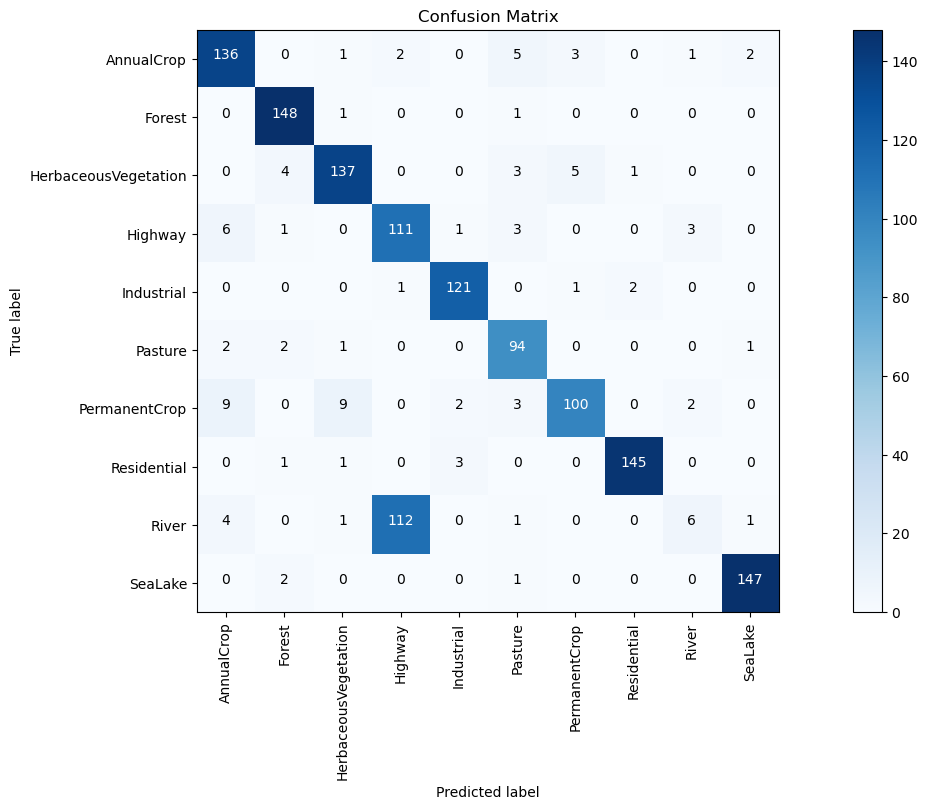

In [21]:
# Make predictions on the test data using the model
predictions = model.predict(test_batches, steps=270, verbose=0)

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):                
    # Create a new figure with the specified size
    plt.figure(figsize=(15, 8))
    # Display the confusion matrix as an image
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)  # Set the title of the plot
    plt.colorbar()  # Add a colorbar to the plot
    
    # Set the tick marks and labels for the x and y axes
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)  # Rotate x-axis labels 90 degrees
    plt.yticks(tick_marks, classes)
            
    # Print whether the confusion matrix is normalized
    if normalize:
        print('Normalized confusion matrix')
    else:
        print('Confusion matrix, without normalization')

    # Print the confusion matrix
    print(cm)

    # Set a threshold to determine text color based on the matrix value
    thresh = cm.max() / 2.
    
    # Iterate over the confusion matrix to add text annotations
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i,j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    
    # Adjust the layout to fit the plot and add labels for the axes
    plt.tight_layout()
    plt.ylabel("True label")  # Label for the y-axis
    plt.xlabel("Predicted label")  # Label for the x-axis


# confusion matrix using the results of the model on the test set
cm = confusion_matrix(test_labels, predictions.argmax(axis=1))
plot_confusion_matrix(cm, categories, title='Confusion Matrix')

In [ ]:
# save trained model, including weights
model.save('land_use_model.keras')

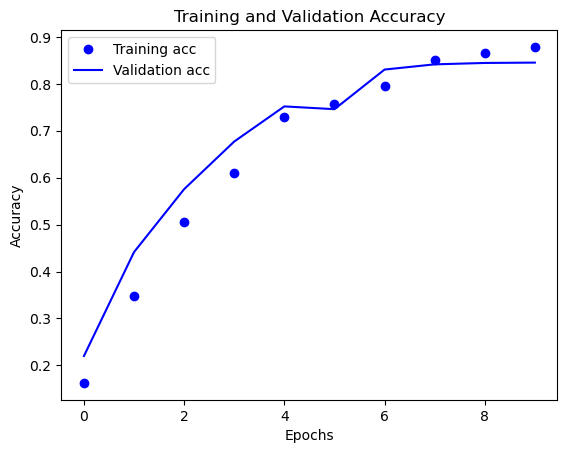

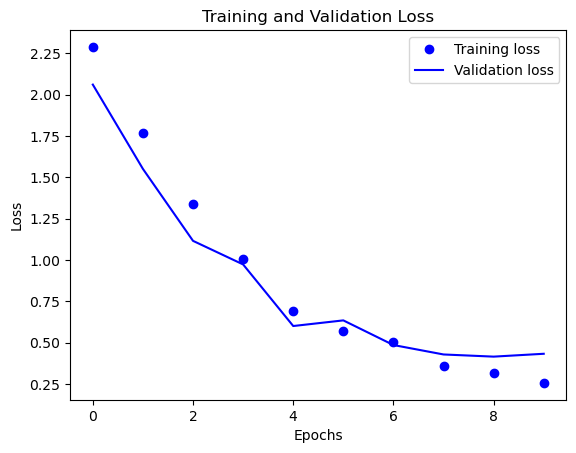

In [22]:
# Extract training and validation accuracy from the history object
acc = history.history['accuracy']  # List of training accuracies for each epoch
val_acc = history.history['val_accuracy']  # List of validation accuracies for each epoch

# Extract training and validation loss from the history object
loss = history.history['loss']  # List of training losses for each epoch
val_loss = history.history['val_loss']  # List of validation losses for each epoch

# Create a range object for the number of epochs
epochs = range(len(acc))  # The range object from 0 to the number of epochs

# Plot training and validation accuracy over epochs
plt.plot(epochs, acc, 'bo', label='Training acc')  # Plot training accuracy with blue dots
plt.plot(epochs, val_acc, 'b', label='Validation acc')  # Plot validation accuracy with a solid blue line
plt.title('Training and Validation Accuracy')  # Title of the accuracy plot
plt.xlabel('Epochs')  # X-axis label
plt.ylabel('Accuracy')  # Y-axis label
plt.legend()  # Display the legend to differentiate between training and validation accuracy

# Create a new figure for the loss plot
plt.figure()

# Plot training and validation loss over epochs
plt.plot(epochs, loss, 'bo', label='Training loss')  # Plot training loss with blue dots
plt.plot(epochs, val_loss, 'b', label='Validation loss')  # Plot validation loss with a solid blue line
plt.title('Training and Validation Loss')  # Title of the loss plot
plt.xlabel('Epochs')  # X-axis label
plt.ylabel('Loss')  # Y-axis label
plt.legend()  # Display the legend to differentiate between training and validation loss

# Display the plots
plt.show()  # Show the training and validation accuracy and loss plots

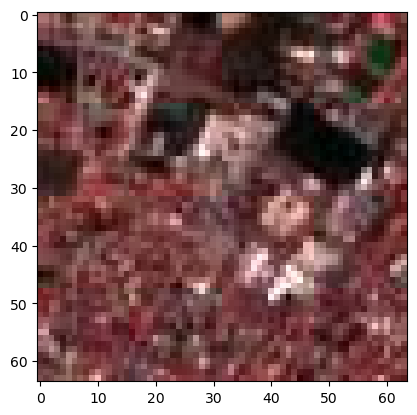

Image tensor shape: (1, 64, 64, 3)


In [23]:
# Load and preprocess the image
img_path = test_path + '/Residential/Residential_26.jpeg'
img = image.load_img(img_path, target_size=(64, 64))
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)
img_tensor /= 255.

# Visualize the image
plt.imshow(img_tensor[0])
plt.show()

# Ensure the shape matches the model's input requirements
print("Image tensor shape:", img_tensor.shape) 

In [24]:
# Assuming `img` is your input image
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)

# Use model.predict to get probabilities for each class
predictions = model.predict(x, batch_size=10)

# Use np.argmax to get the index of the class with the highest probability
predicted_class_index = np.argmax(predictions, axis=1)[0]

print("Predicted class index is:", predicted_class_index)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 277ms/step
Predicted class index is: 7


In [25]:
# Ensure the model is built by running it on some input data
_ = model.predict(np.zeros((1, 64, 64, 3)))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


In [26]:
# Extract intermediate layer outputs
layer_outputs = [layer.output for layer in model.layers[:10]]  # Extracts the outputs of the top 10 layers

# Print each layer output details
for i, output in enumerate(layer_outputs):
    print(f"Layer {i+1} Output:")
    print(f"  Shape: {output.shape}")
    print(f"  Data Type: {output.dtype}")
    print(f"  Sparse: {output.sparse}")
    print(f"  Name: {output.name}")
    print()  # Print an empty line for separation

Layer 1 Output:
  Shape: (None, 64, 64, 64)
  Data Type: float32
  Sparse: False
  Name: keras_tensor_64

Layer 2 Output:
  Shape: (None, 64, 64, 64)
  Data Type: float32
  Sparse: False
  Name: keras_tensor_65

Layer 3 Output:
  Shape: (None, 32, 32, 64)
  Data Type: float32
  Sparse: False
  Name: keras_tensor_66

Layer 4 Output:
  Shape: (None, 32, 32, 128)
  Data Type: float32
  Sparse: False
  Name: keras_tensor_67

Layer 5 Output:
  Shape: (None, 32, 32, 128)
  Data Type: float32
  Sparse: False
  Name: keras_tensor_68

Layer 6 Output:
  Shape: (None, 16, 16, 128)
  Data Type: float32
  Sparse: False
  Name: keras_tensor_69

Layer 7 Output:
  Shape: (None, 16, 16, 256)
  Data Type: float32
  Sparse: False
  Name: keras_tensor_70

Layer 8 Output:
  Shape: (None, 16, 16, 256)
  Data Type: float32
  Sparse: False
  Name: keras_tensor_71

Layer 9 Output:
  Shape: (None, 16, 16, 256)
  Data Type: float32
  Sparse: False
  Name: keras_tensor_72

Layer 10 Output:
  Shape: (None, 16, 16,

In [27]:
# Create a new model that will return the outputs of the top 10 layers given the VGG16 input
activation_model = models.Model(inputs=vgg16_model.input, outputs=layer_outputs)

In [29]:
activations = activation_model.predict(img_tensor)

# Define layer names for plotting
# Extract the names of the first 10 layers from the VGG16 model to use as titles for the plots
layer_names = [layer.name for layer in vgg16_model.layers[:10]]

# Define how many images to display per row
images_per_row = 16  # Number of feature maps to display per row in the grid

# Display the activations
# Iterate through each layer and its corresponding activation tensor
for layer_name, layer_activation in zip(layer_names, activations):
    # `layer_activation` has the shape (1, size, size, n_features)
    n_features = layer_activation.shape[-1]  # Number of feature maps (channels) in the activation tensor
    size = layer_activation.shape[1]  # Size of each feature map (assuming square feature maps)
    n_cols = n_features // images_per_row  # Number of rows needed for the grid to display all feature maps
    
    # Initialize a blank grid to hold the feature maps
    display_grid = np.zeros((size * n_cols, images_per_row * size))
    
    # Loop through each column of the grid
    for col in range(n_cols):  # Create a grid with `images_per_row` columns and `n_cols` rows
        # Loop through each row of the grid
        for row in range(images_per_row):
            # Extract the activation for the specific filter
            channel_image = layer_activation[0, :, :, col * images_per_row + row]
            # Normalize the feature map to have zero mean and unit variance
            channel_image -= channel_image.mean()  # Center the data around zero
            if channel_image.std() > 0:
                channel_image /= channel_image.std()  # Normalize the data to have unit variance
            # Enhance contrast for better visualization
            channel_image *= 64  # Scale the data
            channel_image += 128  # Offset the data
            # Clip the data to be in the range [0, 255] and convert to uint8 for display
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            # Place the image into the correct position in the grid
            display_grid[col * size : (col + 1) * size, row * size : (row + 1) * size] = channel_image
    
    # Define the scale for the figure size based on the size of the feature maps
    scale = 1. / size
    # Create a new figure for the current layer
    plt.figure(figsize=(scale * display_grid.shape[1], scale * display_grid.shape[0]))
    plt.title(layer_name)  # Set the title of the figure to the layer's name
    plt.grid(False)  # Disable the grid to make the feature maps clearer
    plt.imshow(display_grid, aspect='auto', cmap='viridis')  # Display the feature maps using the 'viridis' colormap

# Show all the figures
plt.show()

KeyError: 'Exception encountered when calling Functional.call().\n\n\x1b[1m1769630671184\x1b[0m\n\nArguments received by Functional.call():\n  • inputs=tf.Tensor(shape=(1, 64, 64, 3), dtype=float32)\n  • training=False\n  • mask=None'